
# Gender Prediction from Tweets — Supervised, Unsupervised, and Deep Learning

This notebook builds **three** approaches to predict an author's gender from their tweets:
1. **Supervised**: TF‑IDF + Logistic Regression (baseline) and Linear SVM
2. **Unsupervised**: K‑Means clustering with post‑hoc label alignment
3. **Deep Learning**: A simple Keras model on tokenized text

It also includes **feature analysis** (most predictive n‑grams) and **visualizations** (confusion matrices, ROC, and clustering quality).


In [3]:

import os, glob, re, json, math, itertools, collections
from pathlib import Path

import numpy as np
import pandas as pd

import spacy

import nltk
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, roc_curve,
                             precision_recall_fscore_support, accuracy_score)
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt

nltk.download('stopwords', quiet=True)
STOPWORDS = set(stopwords.words('english'))

In [5]:
!python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.7.1/en_core_web_sm-3.7.1-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [11]:
# Configuration
DATA_DIR = "./en"
TRUTH_FILENAME = "truth.txt"
RANDOM_STATE = 42
# for feature analysis
N_TOP_FEATURES = 20 
# min doc frequency for TF-IDF
MIN_DF = 2           


### Optional: Enable spaCy Lemmatization
Run this cell **once** to download a small English model if you want lemmatization.
If you don't need it, you can skip this section.


In [ ]:

# If you want spaCy-based lemmatization, run this cell ONCE, then set USE_SPACY = True below.
USE_SPACY = False  # set True after running the two lines below

# !python -m spacy download en_core_web_sm
# import spacy; nlp = spacy.load("en_core_web_sm")

# When USE_SPACY is True, we'll build a lemmatizer here:
try:
    if USE_SPACY:
        import spacy
        nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])
        LEMMATIZER_READY = True
    else:
        LEMMATIZER_READY = False
except Exception as e:
    print("spaCy not available or model not loaded. Proceeding without lemmatization.")
    LEMMATIZER_READY = False

In [ ]:

def read_truth_file(truth_path):
    """Read truth file of format: <id>:::<gender>:::<country> per line."""
    rows = []
    with open(truth_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line or ':::' not in line:
                continue
            parts = line.split(":::")
            if len(parts) >= 2:
                _id, gender = parts[0].strip(), parts[1].strip().lower()
                country = parts[2].strip().lower() if len(parts) >= 3 else None
                rows.append((_id, gender, country))
    df = pd.DataFrame(rows, columns=["id","gender","country"])
    return df

def parse_xml_file(xml_path):
    """Extract all <document>...</document> contents from the provided XML."""
    txt = Path(xml_path).read_text(encoding='utf-8', errors='ignore')
    # Naive extraction of CDATA content inside <document> tags
    docs = re.findall(r'<document>\s*<!\[CDATA\[(.*?)\]\]>\s*</document>', txt, flags=re.DOTALL)
    docs = [re.sub(r'\s+', ' ', d).strip() for d in docs]
    return docs

URL_PATTERN = re.compile(r'https?://\S+|www\.\S+')
MENTION_PATTERN = re.compile(r'@\w+')
HASHTAG_PATTERN = re.compile(r'#\w+')
EMOJI_PATTERN = re.compile(r'[\U00010000-\U0010ffff]', flags=re.UNICODE)

def normalize_text(s):
    s = s.lower()
    s = URL_PATTERN.sub(' ', s)
    s = MENTION_PATTERN.sub(' ', s)
    s = HASHTAG_PATTERN.sub(' ', s)
    s = EMOJI_PATTERN.sub(' ', s)
    s = re.sub(r'[^a-z\s]', ' ', s)  # keep only letters and spaces
    s = re.sub(r'\s+', ' ', s).strip()
    return s

def maybe_lemmatize(s):
    doc = nlp(s)
    return ' '.join([t.lemma_ for t in doc if not t.is_stop])

def load_dataset(data_dir, truth_filename):
    truth_path = os.path.join(data_dir, truth_filename)
    truth_df = read_truth_file(truth_path)
    truth_ids = set(truth_df['id'])

    records = []
    xml_files = glob.glob(os.path.join(data_dir, '*.xml'))
    for x in xml_files:
        _id = os.path.splitext(os.path.basename(x))[0]
        docs = parse_xml_file(x)
        raw_text = ' '.join(docs)
        text = normalize_text(raw_text)
        text = maybe_lemmatize(text)
        gender = None
        country = None
        if _id in truth_ids:
            row = truth_df[truth_df['id'] == _id].iloc[0]
            gender = row['gender']
            country = row['country']
        records.append({'id': _id, 'text': text, 'raw_text': raw_text, 'gender': gender, 'country': country})
    df = pd.DataFrame(records)
    # drop where gender is missing
    df = df.dropna(subset=['gender']).reset_index(drop=True)
    return df, truth_df

df, truth_df = load_dataset(DATA_DIR, TRUTH_FILENAME)
print(f"Loaded {len(df)} authors with labels. Example IDs: {df['id'].head().tolist()}\nLabel distribution:\n{df['gender'].value_counts(dropna=False)}")


Loaded 3600 authors with labels. Example IDs: ['1003de26f870d27f79887272a1eb3612', '102cce280df9f6e0e78bfdd266f1abb5', '10488b3700fa9d2db22961ab064e4d38', '1064bd0b78f14bea5b851e2a995dd4e5', '106aa0abb81873d09028b01658c37611']
Label distribution:
gender
male      1800
female    1800
Name: count, dtype: int64


Basic EDA:
       gender       n_chars     n_tokens
count    3600   3600.000000  3600.000000
unique      2           NaN          NaN
top      male           NaN          NaN
freq     1800           NaN          NaN
mean      NaN   9369.971667  1241.141667
std       NaN   1741.237660   261.603198
min       NaN   3319.000000   200.000000
25%       NaN   8211.750000  1066.750000
50%       NaN   9449.000000  1238.000000
75%       NaN  10600.000000  1419.000000
max       NaN  14261.000000  2377.000000


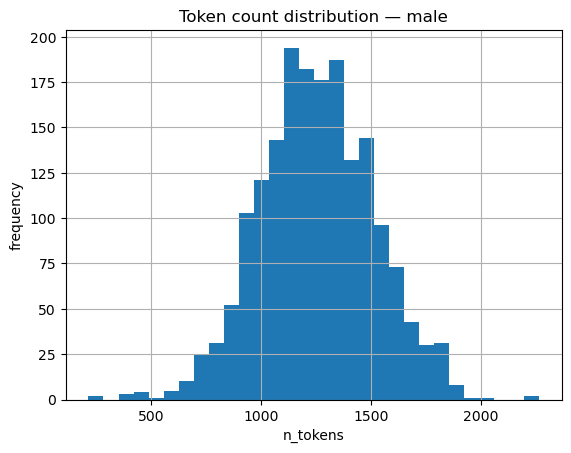

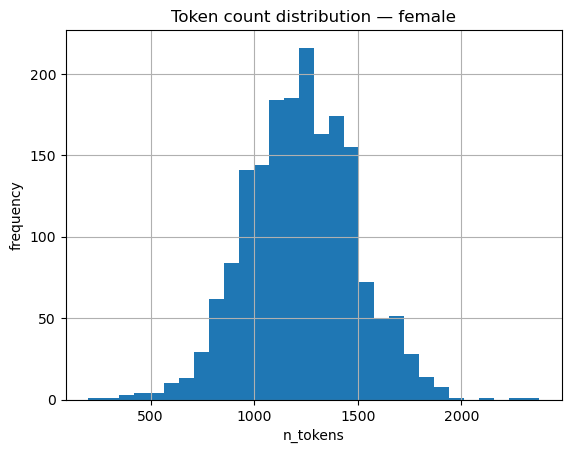

In [4]:

df['n_chars'] = df['raw_text'].str.len()
df['n_tokens'] = df['text'].str.split().apply(len)

print("Basic EDA:")
print(df[['gender','n_chars','n_tokens']].describe(include='all'))

# Plot token count distribution by gender (if enough data)
if df['gender'].nunique() == 2 and len(df) > 5:
    for g in df['gender'].unique():
        subset = df[df['gender'] == g]['n_tokens']
        plt.figure()
        subset.hist(bins=30)
        plt.title(f"Token count distribution — {g}")
        plt.xlabel("n_tokens")
        plt.ylabel("frequency")
        plt.show()


In [5]:

# Safety checks for small samples
if len(df) < 6 or df['gender'].nunique() < 2:
    print("⚠️ Not enough labeled samples with both genders to train/evaluate. Add more XML files and re-run.")
else:
    X_train, X_test, y_train, y_test = train_test_split(
        df['text'].values, df['gender'].values, test_size=0.2, stratify=df['gender'], random_state=RANDOM_STATE
    )
    print(f"Train: {len(X_train)} | Test: {len(X_test)}")


Train: 2880 | Test: 720


## Supervised Model — TF‑IDF + Logistic Regression

              precision    recall  f1-score   support

      female     0.8257    0.8028    0.8141       360
        male     0.8081    0.8306    0.8192       360

    accuracy                         0.8167       720
   macro avg     0.8169    0.8167    0.8166       720
weighted avg     0.8169    0.8167    0.8166       720

Confusion matrix (rows=true, cols=pred):
 [[289  71]
 [ 61 299]]


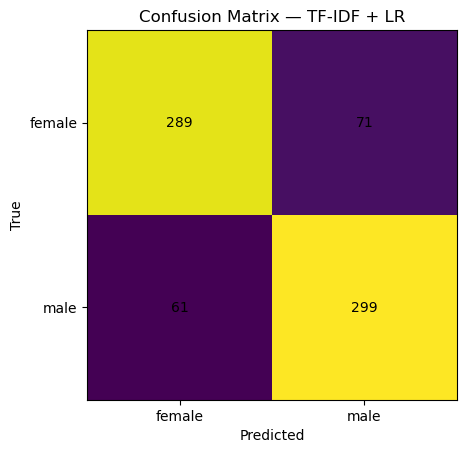

ROC AUC: 0.8818287037037036


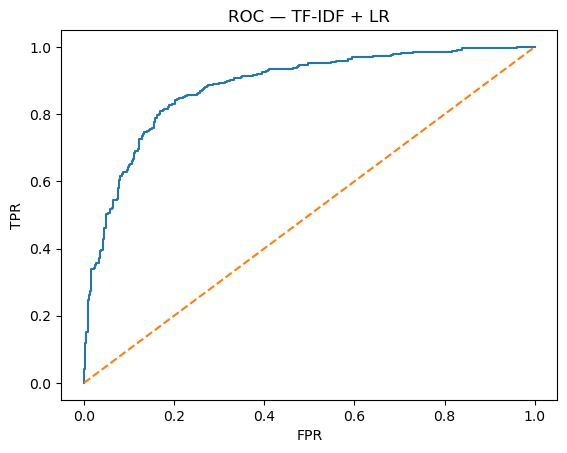

,female (more likely),male (more likely)
0,my,the
1,so,mate
2,amp,that
3,women,game
4,love,bro
5,xx,if
6,more for,fucking
7,thank you,fuck
8,thank,play
9,this,man


In [6]:

if len(df) >= 6 and df['gender'].nunique() == 2:
    tfidf_lr = Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=(1,2), min_df=MIN_DF, max_features=50000)),
        ('lr', LogisticRegression(max_iter=2000, class_weight='balanced', n_jobs=None))
    ])
    tfidf_lr.fit(X_train, y_train)
    pred = tfidf_lr.predict(X_test)
    proba = None
    try:
        proba = tfidf_lr.predict_proba(X_test)[:,1]  # probability of 'male' if label encoder alphabetical may differ
    except Exception:
        pass

    print(classification_report(y_test, pred, digits=4))
    cm = confusion_matrix(y_test, pred, labels=['female','male'])
    print("Confusion matrix (rows=true, cols=pred):\n", cm)

    # Confusion matrix plot
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title("Confusion Matrix — TF-IDF + LR")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks([0,1], ['female','male'])
    plt.yticks([0,1], ['female','male'])
    for (i,j), val in np.ndenumerate(cm):
        plt.text(j, i, int(val), ha='center', va='center')
    plt.show()

    # ROC curve if we have probabilities
    if proba is not None and len(np.unique(y_test)) == 2:
        # Map labels to {0,1}
        classes = sorted(np.unique(y_test))
        pos_label = classes.index('male')  # use 'male' as positive for consistency
        # Build binary vector (1 if male else 0)
        y_bin = np.array([1 if y=='male' else 0 for y in y_test])
        try:
            auc = roc_auc_score(y_bin, proba)
            fpr, tpr, thr = roc_curve(y_bin, proba)
            print("ROC AUC:", auc)
            plt.figure()
            plt.plot(fpr, tpr)
            plt.plot([0,1],[0,1],'--')
            plt.title("ROC — TF-IDF + LR")
            plt.xlabel("FPR")
            plt.ylabel("TPR")
            plt.show()
        except Exception as e:
            print("ROC could not be computed:", e)

    # Feature analysis: top n-grams per class
    vec = tfidf_lr.named_steps['tfidf']
    clf = tfidf_lr.named_steps['lr']
    if hasattr(clf, 'coef_'):
        feature_names = np.array(vec.get_feature_names_out())
        coefs = clf.coef_[0]
        top_pos = np.argsort(coefs)[-N_TOP_FEATURES:][::-1]
        top_neg = np.argsort(coefs)[:N_TOP_FEATURES]

        top_pos_terms = feature_names[top_pos]
        top_neg_terms = feature_names[top_neg]

        df_feats = pd.DataFrame({
            'female (more likely)' : top_neg_terms,
            'male (more likely)'   : top_pos_terms
        })
        try:
            import caas_jupyter_tools as cj
            cj.display_dataframe_to_user("Top predictive n‑grams (LR)", df_feats)
        except Exception:
            display(df_feats)


### (Optional) Linear SVM baseline

In [7]:

if len(df) >= 6 and df['gender'].nunique() == 2:
    tfidf_svm = Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=(1,2), min_df=MIN_DF, max_features=50000)),
        ('svm', LinearSVC())
    ])
    tfidf_svm.fit(X_train, y_train)
    pred_svm = tfidf_svm.predict(X_test)
    print(classification_report(y_test, pred_svm, digits=4))


              precision    recall  f1-score   support

      female     0.8219    0.8333    0.8276       360
        male     0.8310    0.8194    0.8252       360

    accuracy                         0.8264       720
   macro avg     0.8265    0.8264    0.8264       720
weighted avg     0.8265    0.8264    0.8264       720



## Unsupervised — K‑Means clustering (k=2)

In [8]:

if len(df) >= 6 and df['gender'].nunique() == 2:
    tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=MIN_DF, max_features=50000)
    X_all = tfidf.fit_transform(df['text'])
    kmeans = KMeans(n_clusters=2, random_state=RANDOM_STATE, n_init=10)
    clusters = kmeans.fit_predict(X_all)

    # Align clusters to labels by majority vote
    mapping = {}
    for c in [0,1]:
        idx = np.where(clusters == c)[0]
        if len(idx) == 0: 
            continue
        majority = df.iloc[idx]['gender'].mode()
        mapping[c] = majority.iloc[0] if len(majority)>0 else 'female'
    pred_labels = [mapping.get(c, 'female') for c in clusters]

    ari = adjusted_rand_score(df['gender'], pred_labels)
    sil = silhouette_score(X_all, clusters) if len(set(clusters)) > 1 else float('nan')
    print(f"Adjusted Rand Index: {ari:.4f}")
    print(f"Silhouette Score: {sil:.4f}")

    # Simple comparison table
    unsup_acc = accuracy_score(df['gender'], pred_labels)
    print(f"Clustering accuracy (after alignment): {unsup_acc:.4f}")


Adjusted Rand Index: 0.0000
Silhouette Score: 0.0497
Clustering accuracy (after alignment): 0.5069


## Deep Learning — Simple Keras text classifier

c:\Users\erenu\miniconda3\envs\gender_identification\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.5201 - loss: 0.6892 - val_accuracy: 0.6076 - val_loss: 0.6584
Epoch 2/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.7427 - loss: 0.5347 - val_accuracy: 0.6562 - val_loss: 0.6745
Epoch 3/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9456 - loss: 0.1640 - val_accuracy: 0.5660 - val_loss: 1.0020
Epoch 4/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9900 - loss: 0.0311 - val_accuracy: 0.5382 - val_loss: 1.5647
Epoch 5/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.9938 - loss: 0.0274 - val_accuracy: 0.6181 - val_loss: 1.4132
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
              precision    recall  f1-score   support

      female     0.6537    0.6556    0.6546       360
        male     0.6546    0.6528    0.6537       360

    accuracy                         0.6542       720
   macro avg     0.6542    0.6542    0.6542       720
weighted avg     0.6542    0.6542    0.6542       720



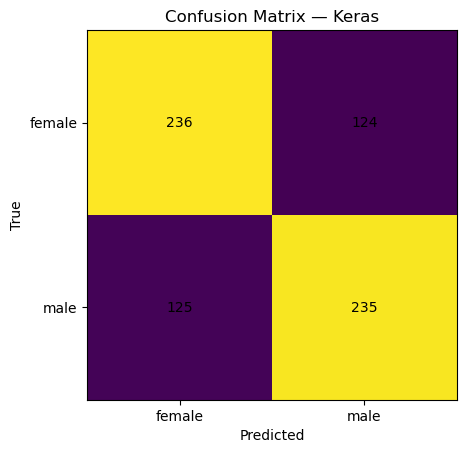

ROC AUC (Keras): 0.6859722222222223


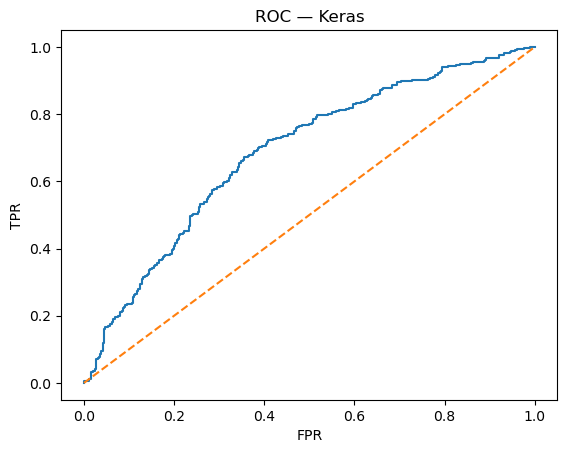

In [9]:

if len(df) >= 20 and df['gender'].nunique() == 2:
    # Use train/test split defined earlier
    # Tokenize
    max_words = 30000
    max_len = 200

    tok = Tokenizer(num_words=max_words, oov_token="<OOV>")
    tok.fit_on_texts(df['text'].values)
    X_tr = tok.texts_to_sequences(X_train)
    X_te = tok.texts_to_sequences(X_test)
    X_tr = pad_sequences(X_tr, maxlen=max_len)
    X_te = pad_sequences(X_te, maxlen=max_len)

    label_index = {'female':0, 'male':1}
    y_tr = np.array([label_index[y] for y in y_train])
    y_te = np.array([label_index[y] for y in y_test])

    model = keras.Sequential([
        keras.layers.Embedding(input_dim=min(max_words, len(tok.word_index)+1), output_dim=64, input_length=max_len),
        keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=False)),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(X_tr, y_tr, validation_split=0.1, epochs=5, batch_size=32, verbose=1)

    # Evaluate
    dl_proba = model.predict(X_te).ravel()
    dl_pred = (dl_proba >= 0.5).astype(int)
    print(classification_report(y_te, dl_pred, target_names=['female','male'], digits=4))

    # Confusion Matrix
    cm = confusion_matrix(y_te, dl_pred)
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title("Confusion Matrix — Keras")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks([0,1], ['female','male'])
    plt.yticks([0,1], ['female','male'])
    for (i,j), val in np.ndenumerate(cm):
        plt.text(j, i, int(val), ha='center', va='center')
    plt.show()

    # ROC
    from sklearn.metrics import roc_curve, roc_auc_score
    auc = roc_auc_score(y_te, dl_proba)
    fpr, tpr, thr = roc_curve(y_te, dl_proba)
    print("ROC AUC (Keras):", auc)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0,1],[0,1],'--')
    plt.title("ROC — Keras")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.show()
else:
    print("Deep learning section skipped (need at least 20 labeled samples across both classes).")


## Compare Models

In [10]:

results = []

def evaluate_pipeline(clf, name):
    pred = clf.predict(X_test)
    p, r, f1, _ = precision_recall_fscore_support(y_test, pred, average='weighted', zero_division=0)
    acc = accuracy_score(y_test, pred)
    results.append({'model': name, 'accuracy': acc, 'precision': p, 'recall': r, 'f1': f1})

if len(df) >= 6 and df['gender'].nunique() == 2:
    evaluate_pipeline(tfidf_lr, "TF-IDF + LogisticRegression")
    try:
        evaluate_pipeline(tfidf_svm, "TF-IDF + LinearSVM")
    except Exception:
        pass

    # Unsupervised uses all data; we approximate test metrics by overall acc
    # This is just for table comparison purpose
    try:
        results.append({'model':'KMeans (k=2) aligned', 'accuracy': unsup_acc, 'precision': float('nan'), 'recall': float('nan'), 'f1': float('nan')})
    except Exception:
        pass

    # Deep learning summary if available
    try:
        # reuse dl_pred and y_te if defined
        from sklearn.metrics import accuracy_score, precision_recall_fscore_support
        if 'dl_pred' in globals():
            p, r, f1, _ = precision_recall_fscore_support(y_te, dl_pred, average='weighted', zero_division=0)
            acc = accuracy_score(y_te, dl_pred)
            results.append({'model':'Keras BiLSTM', 'accuracy': acc, 'precision': p, 'recall': r, 'f1': f1})
    except Exception:
        pass

    if results:
        res_df = pd.DataFrame(results)
        try:
            import caas_jupyter_tools as cj
            cj.display_dataframe_to_user("Model comparison", res_df)
        except Exception:
            display(res_df)
    else:
        print("No results to compare yet.")
else:
    print("Not enough data to compare models.")


,model,accuracy,precision,recall,f1
0,TF-IDF + LogisticRegression,0.816667,0.816911,0.816667,0.816631
1,TF-IDF + LinearSVM,0.826389,0.826452,0.826389,0.826381
2,KMeans (k=2) aligned,0.506944,NaN,NaN,NaN
3,Keras BiLSTM,0.654167,0.654168,0.654167,0.654166
